In [207]:
import os

os.chdir('/homes/gws/taugust/ARK/community_guidelines')

%run Reddit/SRILM_building_funcs.ipynb

/homes/gws/taugust/ARK/community_guidelines


# Getting author counts for posts vs. comments

In [3]:
def split_authorship(df_author_counts):
    # get comment and post author counts
    print('Splitting author counts to post & comment....', end='')
    df_author_counts_post = df_author_counts[df_author_counts['kind'] == 'post']
    df_author_counts_comment = df_author_counts[df_author_counts['kind'] == 'comment']
    print('Done')

    # get their intersection and difference
    print('Getting intersection and difference of these....', end='')
    authors_intersect = list(set(df_author_counts_post['author']) & set(df_author_counts_comment['author']))
    authors_diff = list(set(df_author_counts_post['author']).symmetric_difference(set(df_author_counts_comment['author'])))

    # get author counts of those who post and comment, and those who only post or only comment
    df_author_post_comment = df_author_counts[df_author_counts['author'].apply(lambda x: x in authors_intersect)]
    df_author_only_post_comment = df_author_counts[df_author_counts['author'].apply(lambda x: x in authors_diff)]
    print('Done')

    # Get total counts
    print('Getting total counts.....', end='')
    for_months = [str(i) for i in range(1,13)]
    df_author_post_comment['total'] = df_author_post_comment[for_months].sum(axis=1, numeric_only=True)
    df_author_only_post_comment['total'] = df_author_only_post_comment[for_months].sum(axis=1, numeric_only=True)
    print('Done')
    
    # combine into an easy to use df
    df_author_post_comment['type'] = 'xor'
    df_author_only_post_comment['type'] = 'and'
    df_combined = df_author_only_post_comment[['total', 'kind', 'type']].append(df_author_post_comment[['total', 'kind', 'type']])
    
    return df_combined

def plot_authorship(df_authorship, ax, title):
    sns.barplot(x='kind', y='total', hue='type', data=df_authorship, ax=ax)
    ax.set_title("Number of authors of posts and comments--" + title, fontsize=30)
    ax.legend(title="post ___ comment")
    ax.tick_params(axis='both', which='major', labelsize=25)
    



# simpler function for just importing a csv
def import_csv(sub, path, ext):

    path = path+sub+ext
    
    print('Importing ', colored(path, 'magenta'),'.....', end=' ')
    df = pd.read_csv(path, quoting=csv.QUOTE_ALL, escapechar='\\')
    print('Done')
    
    return df

In [6]:
df_author_counts = import_csv('science', path='data/cleaned/sub_author_counts/', 
                                                       ext='_author_counts_2017.csv')

Importing  data/cleaned/sub_author_counts/science_author_counts_2017.csv ..... Done


In [14]:
subreddits = ['depression', 'Cooking', 'Naruto', 'BabyBumps','pics', 'science', 'politics']
fig, axs = plt.subplots(1, len(subreddits) , sharey=True, tight_layout=True)
fig.set_figheight(50)
fig.set_figwidth(50)

for i, s in enumerate(subreddits):
    df_author_counts = import_csv(s, path='data/cleaned/sub_author_counts/', 
                                                       ext='_author_counts_2017.csv')

    df_authorship = split_authorship(df_author_counts)
    plot_authorship(df_authorship,axs[i], title=s)

# Getting Deleted Comments

https://www.reddit.com/r/bigquery/comments/8ljjmo/reddit_submissions_are_now_being_streamed_to/: useful thread showing that deleted posts can either be author deleted or automod deleted


Seeing if deleted comments have a distinct language style - i.e. are very different from inside comments

Try: gap from inside comments? Gap from outside comments?

Text(0.5, 1.0, 'Percent of deleted posts compared to total')

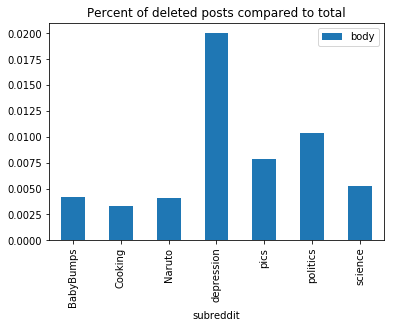

In [181]:
# get deleted comments and plot the percent of deleted comments vs. total comments
df_comments_deleted = pd.read_csv('data/cleaned/cleaned_comments_deleted_2017.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
df_comments_cleaned = pd.read_csv('data/cleaned/cleaned_comments_2017.csv', quoting=csv.QUOTE_ALL, escapechar='\\')


percent_deleted = df_comments_deleted.groupby(['subreddit'])['body'].count()/df_comments_cleaned.groupby(['subreddit'])['body'].count()
df_percent_deleted = pd.DataFrame(percent_deleted).reset_index()
df_percent_deleted.plot(kind='bar', x='subreddit', y='body')
plt.title('Percent of deleted posts compared to total')


In [182]:
# get slms trained on comments
comment_based_slms = build_monthly_SLM_SRILM(None, None, 10, name='politics', use_saved_lms=True, kind='comment')


In [213]:
def convert_month_to_string(month):
    if month is not None:
        return str(month)
    else:
        return 'Total'
    
def calc_acc_gap(active_ent, outside_ent):
    exp_val_active_ent = np.mean(active_ent)
    exp_val_outside_ent = np.mean(outside_ent)
    return (exp_val_outside_ent - exp_val_active_ent) / exp_val_active_ent
    
def get_deleted_text(df_deleted, month, subreddit, sample=50):
    df_comments_deleted_sub = df_deleted[df_deleted['subreddit'] == subreddit]
    df_comments_deleted_sub_month = df_comments_deleted_sub[df_comments_deleted_sub['created_month'] == month]
    
    sampled = df_comments_deleted_sub_month.sample(sample)
    sampled_text = sampled['body'].apply(lambda x: word_tokenize(x)[:10]) 

    return sampled_text

def get_active_user_text(author_counts, df_text, month, subreddit, num_authors=5, num_posts=10, kind='comment'):
    active_authors = get_active_users(author_counts, month, 'author', threshold=10, num_authors=num_authors, kind=kind)
    active_comments = get_user_comments(df_text, list(active_authors), month=month, num_posts=num_posts)
    
    return active_comments

def get_acc_gap_deleted_text(deleted_text, active_text, slms, sub_name, month):
    month_string = convert_month_to_string(month)
    
    
    # export the deleted text
    name = str(uuid.uuid4())
    deleted_corpus_file = export_text(deleted_text, name=name, corpus_path='data/tmp/')
    active_corpus_file = export_text(active_text, name=sub_name+'_inside_month_'+month_string, corpus_path='../data/srilm_data/test')

    active_ent = calc_month_entropy_SRILM(slms[month], active_corpus_file)
    deleted_ent = calc_month_entropy_SRILM(slms[month], deleted_corpus_file)

    acc_gap = calc_acc_gap(active_ent, deleted_ent)
    
    return acc_gap

In [ ]:
df_comments_politics, df_author_counts_politics = import_csvs('politics', path='data/cleaned/train/2017/', ext='_train_2017.csv', comment_pre_path='data/cleaned/sub_comments/', comment_ext='_comments_2017.csv')

acc_gaps_deleted = []
acc_gaps_normal = []


for m in range(1, 13):
    deleted_text = get_deleted_text(df_comments_deleted, m, 'politics')
    active_text = get_active_user_text(df_author_counts_politics, df_comments_politics, str(m), 'politics', num_authors=5, num_posts=10, kind='comment')

    get_acc_gap_deleted_text(deleted_text, active_text, comment_based_slms, 'politics', m)

    acc_gap_deleted = get_acc_gap_deleted_text(deleted_text, active_text, comment_based_slms, 'politics', 1)
    acc_gap_normal, _ = calc_single_acc_gap_SRILM(comment_based_slms[1], df_author_counts_politics, df_comments_politics, 'politics', month=1, kind='comment')

    acc_gaps_deleted.append(acc_gap_deleted)
    acc_gaps_normal.append(acc_gap_normal)
    
    print(acc_gap_deleted, acc_gap_normal )

Importing  data/cleaned/sub_comments/politics_comments_2017.csv ..... Done
Importing  data/cleaned/train/2017/author_counts/politics_author_counts_train_2017.csv ..... Done


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


In [214]:
get_acc_gap_deleted_text(deleted_text, active_text, comment_based_slms, 'politics', 1)

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


0.04034005751822085

Calculating cross entropy for month 1 .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


(0.016718141048044796,
 ([7.506966041681171,
   7.655831931443344,
   7.4568118976623765,
   7.484470080474412,
   7.397506076965381,
   7.428479101152479,
   7.615961354323888,
   7.487499212121445,
   7.576594694103056,
   7.630995843281986],
  [7.637604450395547,
   7.701878227758466,
   7.677107907913687,
   7.671177295408796,
   7.524335629009123,
   7.75605521170156,
   7.5310616926668015,
   7.641199185705426,
   7.709178265477774,
   7.649409960971468]))

# Post-Based LM comparison - scratch
Using a seperate notebook for getting a LM based on all posts in community
TODO: join this with the original notebook for SRILM building

In [4]:
%run Reddit/SRILM_building_funcs.ipynb

/homes/gws/taugust/ARK/community_guidelines


In [15]:
subs = ['depression', 'Cooking', 'Naruto', 'BabyBumps','pics', 'science', 'politics']
post_based_slms = {}
for i, s in enumerate(subs):
    print('-----------------------------------------------')
    print('Getting total post-based LMs for ', colored(s, 'magenta'))
    print('-----------------------------------------------')
    post_based_slms[s] = build_total_SLM_SRILM(None, None, slm_count=10, name=s, use_saved_lms=True, kind='post', num_authors=200, threshold_count=3)


-----------------------------------------------
Getting total post-based LMs for  depression
-----------------------------------------------
-----------------------------------------------
Getting total post-based LMs for  Cooking
-----------------------------------------------
-----------------------------------------------
Getting total post-based LMs for  Naruto
-----------------------------------------------
-----------------------------------------------
Getting total post-based LMs for  BabyBumps
-----------------------------------------------
-----------------------------------------------
Getting total post-based LMs for  pics
-----------------------------------------------
-----------------------------------------------
Getting total post-based LMs for  science
-----------------------------------------------
-----------------------------------------------
Getting total post-based LMs for  politics
-----------------------------------------------


# Getting acc gap for comments and posts based on LM trained on POSTS
Interested to see if outside users comment closer to posts than inside users do

## Utility funcs

In [53]:
def get_acc_gap_post(post_slms, s):
    print('Getting avg acc gap for', colored('Posts', 'green'), 'with passed slms')
    df_comments, df_author_counts_test = import_csvs(s, path='data/cleaned/test/2017/', ext='_test_2017.csv', comment_pre_path='data/cleaned/sub_comments/', comment_ext='_comments_2017.csv')    
    
    df_posts, df_author_counts_test = import_csvs(s, path='data/cleaned/test/2017/', ext='_test_2017.csv', comment_pre_path='data/cleaned/sub_posts/', comment_ext='_posts_2017.csv')
    df_posts = df_posts.rename(index=str, columns={'fulltext': 'body'})

    # just run this through 12 times to be similar to comments, but you are taking total LM each time
    total_acc_gap_comments = []
    entropies_comments = {'inside':[], 'outside':[]}
    total_acc_gap_posts = []
    entropies_posts = {'inside':[], 'outside':[]}
    for i in range(1, 13):
        gap_comment, (active_ent_comment, outside_ent_comment) = calc_single_acc_gap_SRILM(post_slms, df_author_counts_test, df_comments, s, kind='comment', month=None,
                                           num_active_authors=5, num_active_posts=10, num_outside_authors=50, num_outside_posts=1)
        total_acc_gap_comments.append(gap_comment)
        entropies_comments['inside'].append(active_ent_comment)
        entropies_comments['outside'].append(outside_ent_comment)
    
        
        gap_post, (active_ent_post, outside_ent_post) = calc_single_acc_gap_SRILM(post_slms, df_author_counts_test, df_posts, s, kind='post', month=None, 
                                            num_active_authors=5, num_active_posts=10, num_outside_authors=50, num_outside_posts=1)
        total_acc_gap_posts.append(gap_post)
        entropies_posts['inside'].append(active_ent_post)
        entropies_posts['outside'].append(outside_ent_post)
    return (total_acc_gap_comments,entropies_comments), (total_acc_gap_posts, entropies_posts)



#     print('Getting avg acc gap for', colored('Posts', 'green'), 'with passed slms')
#     df_posts, df_author_counts_test = import_csvs(s, path='data/cleaned/test/2017/', ext='_test_2017.csv', comment_pre_path='data/cleaned/sub_posts/', comment_ext='_posts_2017.csv')
#     df_posts = df_posts.rename(index=str, columns={'fulltext': 'body'})
    
#     acc_gap_post, (active_ent_post, outside_ent_post) = calc_total_acc_gap_SRILM(post_slms, df_author_counts_test, df_posts, s, kind='post',
#                                        num_active_authors=20, num_active_posts=10, num_outside_authors=200, num_outside_posts=1) 
    
#     df_comments, _ = import_csvs(s, path='data/cleaned/test/2017/', ext='_test_2017.csv', comment_pre_path='data/cleaned/sub_comments/', comment_ext='_comments_2017.csv')    
#     acc_gap_comment, (active_ent_comment, outside_ent_comment) = calc_single_acc_gap_SRILM(post_slms, df_author_counts_test, df_comments, s, kind='comment',
#                                        num_active_authors=20, num_active_posts=10, num_outside_authors=200, num_outside_posts=1)
#     gap_post_post = acc_gap_post_post[0]
#     gap_post_comments = acc_gap_post_comment[0]
#     return gap_post_post, gap_post_comments
# (acc_gap_comment,entropies_comments), (total_acc_gap_posts, entropies_posts)

# assumes SLMs are in dict form with months
def get_acc_gap_comment(slms, s):
    print('Getting avg acc gap for', colored('comments', 'green'), 'with passed slms')
    df_comments, df_author_counts_test = import_csvs(s, path='data/cleaned/test/2017/', ext='_test_2017.csv', comment_pre_path='data/cleaned/sub_comments/', comment_ext='_comments_2017.csv')    
    dict_gap_comments, entropies_comments = calc_acc_gap_SRILM(slms, df_author_counts_test, df_comments, s, kind='comment',
                                       num_active_authors=5, num_active_posts=10, num_outside_authors=50, num_outside_posts=1)
    gap_comments = list(dict_gap_comments.values())


    
    print('Getting average acc gap for', colored('posts', 'green'), 'with passed slms')
    df_posts, df_author_counts_test = import_csvs(s, path='data/cleaned/test/2017/', ext='_test_2017.csv', comment_pre_path='data/cleaned/sub_posts/', comment_ext='_posts_2017.csv')
    df_posts = df_posts.rename(index=str, columns={'fulltext': 'body'})
    total_acc_gap_posts = []
    entropies_posts = {'inside':[], 'outside':[]}
    for month in slms.keys():
        acc_gap, (active_ent, outside_ent) = calc_single_acc_gap_SRILM(slms[month], 
                df_author_counts_test, df_posts, s, kind='post', month=None, 
                num_active_authors=5, num_active_posts=10, num_outside_authors=50, num_outside_posts=1)
        total_acc_gap_posts.append(acc_gap)
    entropies_posts['inside'].append(active_ent)
    entropies_posts['outside'].append(outside_ent)
    
    return (gap_comments,entropies_comments), (total_acc_gap_posts, entropies_posts)


def sample_acc_gap_post(slms, s, sample):
    gap_post_comment = []
    gap_post_post = []
    
    entropies_comments = {'inside':[], 'outside':[]}
    entropies_posts = {'inside':[], 'outside':[]}
    
    for i in range(sample):
        (gap_comments,entropy_comments), (gap_posts, entropy_posts) = get_acc_gap_post(slms[s], s)
        
        gap_post_comment.append(gap_comments)
        entropies_comments['inside'].append(entropy_comments['inside'])
        entropies_comments['outside'].append(entropy_comments['outside'])
        
        gap_post_post.append(gap_posts)
        entropies_posts['inside'].append(entropy_posts['inside'])
        entropies_posts['outside'].append(entropy_posts['outside'])

        
    return (gap_post_comment, entropies_comments), (gap_post_post, entropies_posts)

In [54]:
#####################################################
# Getting gap differences based on post-based LMs
#####################################################
num_samples = 1
rows = []
entropy_rows = []
subs = ['BabyBumps', 'science', 'Naruto', 'pics', 'politics', 'depression', 'Cooking']
for s in subs:
    (gap_post_comment,entropies_comments ), (gap_post_post, entropies_posts) = sample_acc_gap_post(post_based_slms, s, num_samples)
    print(len(gap_post_comment))
    for i in range(num_samples):
        rows.append({'sub': s, 'kind':'post_post', 'gap':gap_post_post})
        rows.append({'sub': s, 'kind':'post_comment', 'gap':gap_post_comment})
        
        entropy_rows.append({'sub': s, 'kind':'entropies_comments', 'gap':entropies_comments})
        entropy_rows.append({'sub': s, 'kind':'entropies_posts', 'gap':entropies_posts})
        
df_rows = pd.DataFrame(rows)
df_entropy = pd.DataFrame(entropy_rows)

Getting avg acc gap for Posts with passed slms
Importing  data/cleaned/sub_comments/BabyBumps_comments_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/BabyBumps_author_counts_test_2017.csv ..... Done
Importing  data/cleaned/sub_posts/BabyBumps_posts_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/BabyBumps_author_counts_test_2017.csv ..... Done
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled

sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all 

sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all 

No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy fo

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:9: DtypeWarning: Columns (9,12,16,17,18,19,22,26,27,33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':


Done
Importing  data/cleaned/test/2017/author_counts/politics_author_counts_test_2017.csv ..... Done
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross en

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:9: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':


Done
Importing  data/cleaned/test/2017/author_counts/depression_author_counts_test_2017.csv ..... Done
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross 

sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all author counts
No month...taking all author counts
sampled active users: 5 sampled outside users: 50
No month...taking all author counts
No month...taking all author counts
sampled active comments: 50 sampled outside comments: 50
Calculating cross entropy for Total .....
No month...taking all 

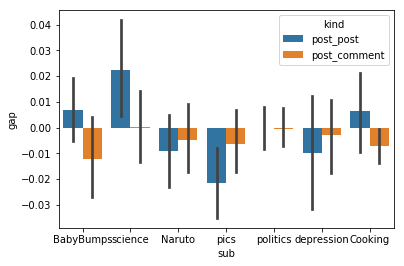

In [79]:
df_rows = pd.DataFrame(rows)
df_rows['gap'] = [x[0] for x in df_rows['gap']]
# https://stackoverflow.com/questions/53218931/how-do-i-unnest-explode-a-column-in-a-pandas-dataframe
exploded_gap_df = pd.DataFrame({'gap':np.concatenate(df_rows.gap.values)},index=df_rows.index.repeat(df_rows.gap.str.len()))
exploded_gap_df = exploded_gap_df.join(df_rows.drop('gap',1),how='left')

sns.barplot(y='gap', x='sub', hue='kind', data=exploded_gap_df)


In [111]:
df_entropy['inside'] = [x['inside'] for x in df_entropy['gap']]
df_entropy['outside'] = [x['outside'] for x in df_entropy['gap']]

df_entropy['inside'] = [np.array(x).flatten() for x in df_entropy['inside']]
df_entropy['outside'] = [np.array(x).flatten() for x in df_entropy['outside']]

exploded_df_entropy_inside = pd.DataFrame({'inside':np.concatenate(df_entropy.inside.values)},index=df_entropy.index.repeat(df_entropy.inside.str.len()))
exploded_df_entropy_inside = exploded_df_entropy_inside.join(df_entropy.drop('inside',1),how='left')

exploded_df_entropy_outside = pd.DataFrame({'outside':np.concatenate(df_entropy.outside.values)},index=df_entropy.index.repeat(df_entropy.outside.str.len()))
exploded_df_entropy_outside = exploded_df_entropy_outside.join(df_entropy.drop('outside',1),how='left')

In [114]:
exploded_df_entropy = exploded_df_entropy_outside[['kind', 'sub', 'outside']].merge(exploded_df_entropy_inside[['kind', 'sub', 'inside']], on=['kind', 'sub'])

In [120]:
exploded_df_entropy['diff'] = exploded_df_entropy['outside'] - exploded_df_entropy['inside']

In [131]:
display(exploded_df_entropy.groupby(['kind', 'sub'])['diff'].mean())

kind                sub       
entropies_comments  BabyBumps    -0.097880
                    Cooking      -0.057318
                    Naruto       -0.040566
                    depression   -0.023965
                    pics         -0.051904
                    politics     -0.005883
                    science      -0.000005
entropies_posts     BabyBumps     0.052618
                    Cooking       0.045208
                    Naruto       -0.074570
                    depression   -0.080105
                    pics         -0.168620
                    politics     -0.001903
                    science       0.172974
Name: diff, dtype: float64

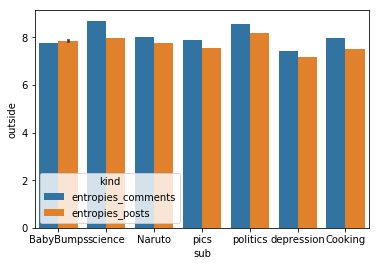

In [118]:
sns.barplot(y='outside', x='sub', hue='kind', data=exploded_df_entropy)


In [100]:
exploded_df_entropy_outside.outside.mean(), exploded_df_entropy_inside.inside.mean()

(7.8832468491226955, 7.9069554615001945)

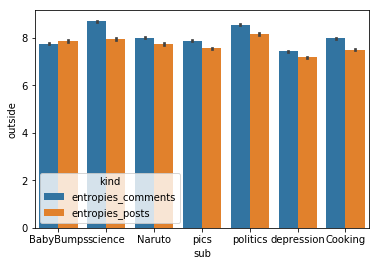

In [97]:
sns.barplot(y='outside', x='sub', hue='kind', data=exploded_df_entropy_outside)


In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# entropies_comments['outside'] = list(flatten(entropies_comments['outside']))
# entropies_comments['inside'] = list(flatten(entropies_comments['inside']))
df_entropies_comments = pd.DataFrame(entropies_comments)
sns.barplot(x='variable', y='value', data=df_entropies_comments.melt(), ax=axs[0])
axs[0].set_title('Comments on comments')


# entropies_posts['outside'] = list(flatten(entropies_posts['outside']))
# entropies_posts['inside'] = list(flatten(entropies_posts['inside']))
df_entropies_posts = pd.DataFrame(entropies_posts)
sns.barplot(x='variable', y='value', data=df_entropies_posts.melt(), ax=axs[1])
axs[1].set_title('Posts on comments-trained')

# Comment pased LM comparison

In [129]:
subs = ['BabyBumps', 'Cooking', 'science', 'Naruto', 'pics', 'politics', 'depression']
comment_based_slms = {}
for i, s in enumerate(subs):
    print('-----------------------------------------------')
    print('Getting montly comment-based SLMs for ', colored(s, 'magenta'))
    print('-----------------------------------------------')
    comment_based_slms[s] = build_monthly_SLM_SRILM(None, None, 10, name=s, use_saved_lms=True, kind='comment')


-----------------------------------------------
Getting montly comment-based SLMs for  BabyBumps
-----------------------------------------------
-----------------------------------------------
Getting montly comment-based SLMs for  Cooking
-----------------------------------------------
-----------------------------------------------
Getting montly comment-based SLMs for  science
-----------------------------------------------
-----------------------------------------------
Getting montly comment-based SLMs for  Naruto
-----------------------------------------------
-----------------------------------------------
Getting montly comment-based SLMs for  pics
-----------------------------------------------
-----------------------------------------------
Getting montly comment-based SLMs for  politics
-----------------------------------------------
-----------------------------------------------
Getting montly comment-based SLMs for  depression
---------------------------------------------

In [50]:


# def get_acc_gap_post_comment(post_slms, s):
#     df_posts, df_author_counts_test = import_csvs(s, path='data/cleaned/test/2017/', ext='_test_2017.csv', comment_pre_path='data/cleaned/sub_posts/', comment_ext='_posts_2017.csv')
#     df_posts = df_posts.rename(index=str, columns={'fulltext': 'body'})
#     acc_gap_post_post = calc_single_acc_gap_SRILM(post_slms, df_author_counts_test, df_posts, s, kind='post', month=None
#                                        num_active_authors=20, num_active_posts=10, num_outside_authors=200, num_outside_posts=1) 
    
#     df_comments, _ = import_csvs(s, path='data/cleaned/test/2017/', ext='_test_2017.csv', comment_pre_path='data/cleaned/sub_comments/', comment_ext='_comments_2017.csv')    
#     acc_gap_post_comment = calc_single_acc_gap_SRILM(post_slms, df_author_counts_test, df_comments, s, kind='comment',, month=None
#                                        num_active_authors=20, num_active_posts=10, num_outside_authors=200, num_outside_posts=1)
#     gap_post_post = acc_gap_post_post[0]
#     gap_post_comments = acc_gap_post_comment[0]
#     return gap_post_post, gap_post_comments

In [130]:
for s in comment_based_slms.keys():
    (gap_comments,entropies_comments), (gap_posts, entropies_posts) = get_acc_gap_comment(comment_based_slms['science'], 'science')

Getting avg acc gap for comments with passed slms
Importing  data/cleaned/sub_comments/science_comments_2017.csv ..... Done
Importing  data/cleaned/test/2017/author_counts/science_author_counts_test_2017.csv ..... Done
Calculating cross entropy for Total .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


Saving acc gap for month 1
Calculating cross entropy for Total .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 2
Calculating cross entropy for Total .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 3
Calculating cross entropy for Total .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 4
Calculating cross entropy for Total .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 5
Calculating cross entropy for Total .....
sampled active users: 5 sampled outside users: 50
sampled active comments: 50 sampled outside comments: 50
Saving acc gap for month 6
Calculating cross entropy for Total .....
sampled active users: 5 sampled outside users: 50
s

In [135]:
np.mean(gap_comments), np.mean(gap_posts)

(0.053520524992435335, 0.018409496486353916)

In [147]:
[np.mean(x) for x in df_rows[df_rows['sub'] == 'science']['gap']]

[0.022486058294126355, 0.00021588303179497872]

,inside,outside
0,7.182199,7.714394
1,7.289956,7.705953
2,7.263878,7.621598
3,7.180882,7.565906
4,7.037459,7.700789
5,7.197902,7.668065
6,7.210752,7.713450
7,7.152134,7.850521
8,7.154904,7.706799
9,7.107774,7.608578


Text(0.5, 1.0, 'Posts on comments-trained')

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


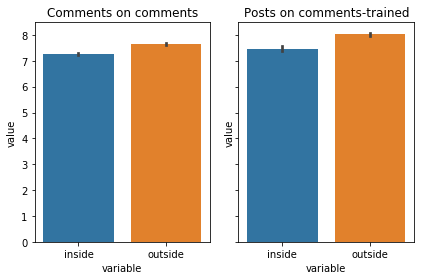

In [150]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# entropies_comments['outside'] = list(flatten(entropies_comments['outside']))
# entropies_comments['inside'] = list(flatten(entropies_comments['inside']))
df_entropies_comments = pd.DataFrame(entropies_comments)
sns.barplot(x='variable', y='value', data=df_entropies_comments.melt(), ax=axs[0])
axs[0].set_title('Comments on comments')


# entropies_posts['outside'] = list(flatten(entropies_posts['outside']))
# entropies_posts['inside'] = list(flatten(entropies_posts['inside']))
df_entropies_posts = pd.DataFrame(entropies_posts)
sns.barplot(x='variable', y='value', data=df_entropies_posts.melt(), ax=axs[1])
axs[1].set_title('Posts on comments-trained')


In [164]:
sci = df_entropy[df_entropy['sub'] == 'science']

sci_comments = sci[sci['kind'] == 'entropies_comments']
sci_posts = sci[sci['kind'] == 'entropies_posts']

sci_comments = pd.DataFrame(sci_comments['gap'].iloc[0])
sci_comments['outside'] = list(flatten(sci_comments['outside']))
# sci_comments['inside'] = list(flatten(sci_comments['inside']))
# sci_comments = pd.DataFrame(sci_comments)
# sns.barplot(x='variable', y='value', data=df_entropies_comments.melt(), ax=axs[0])
# axs[0].set_title('Comments on comments')

sci_posts = pd.DataFrame(sci_posts['gap'].iloc[0])
sci_posts['outside'] = list(flatten(sci_posts['outside']))
sci_posts['inside'] = list(flatten(sci_posts['inside']))
sci_posts = pd.DataFrame(sci_posts)


ValueError: Length of values does not match length of index

,variable,value
0,inside,"[[8.728977589846096, 8.826972018176374, 8.7212..."
1,outside,"[[8.853842864067264, 8.932875257615729, 8.8246..."


In [153]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

sns.barplot(x='variable', y='value', data=df_entropy[df_entropy['kind'] == 'entropies_comments'].melt(), ax=axs[0])
axs[0].set_title('Comments on comments')

df_entropy[df_entropy['kind'] == 'entropies_comments']
df_entropy[df_entropy['kind'] == 'entropies_posts']

,gap,kind,sub,inside,outside
1,"{'inside': [[[7.762722863183825, 7.69811844197...",entropies_posts,BabyBumps,"[7.762722863183825, 7.698118441972208, 8.00661...","[7.927209066670844, 7.752519138629307, 7.86959..."
3,"{'inside': [[[8.017513309184434, 7.96013402821...",entropies_posts,science,"[8.017513309184434, 7.960134028216913, 8.16437...","[8.049139549246721, 7.904494334015234, 7.81013..."
5,"{'inside': [[[7.778334096972873, 7.94200771368...",entropies_posts,Naruto,"[7.778334096972873, 7.942007713687964, 7.73316...","[7.835180687706896, 7.9482597555622325, 7.8609..."
7,"{'inside': [[[7.37411007122944, 7.663533910854...",entropies_posts,pics,"[7.37411007122944, 7.66353391085467, 7.6020507...","[7.429165679361295, 7.228056746343329, 7.32433..."
9,"{'inside': [[[8.051834290489504, 8.05085590655...",entropies_posts,politics,"[8.051834290489504, 8.050855906552519, 8.23861...","[8.286655709075164, 8.081633092465768, 8.20156..."
11,"{'inside': [[[6.9727271128691894, 7.0604062829...",entropies_posts,depression,"[6.9727271128691894, 7.060406282934603, 7.0493...","[7.337007232037633, 7.437828625703466, 7.39602..."
13,"{'inside': [[[7.403997918929092, 7.47472967936...",entropies_posts,Cooking,"[7.403997918929092, 7.4747296793625155, 7.4729...","[7.191229020481362, 6.9856222436354205, 7.0095..."
